In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, signal
import numpy as np
from sklearn import preprocessing

In [2]:
df = pd.read_csv('skab.csv',sep=";",index_col=0,parse_dates=True)

In [3]:
df.describe()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
count,9401.000000,9401.000000,9401.000000,9401.000000,9401.000000,9401.000000,9401.000000,9401.000000
mean,0.212277,0.268553,2.568057,0.111429,89.506955,28.417508,228.490887,125.140908
std,0.004728,0.004129,6.082034,0.252583,0.673482,0.757808,12.579837,1.671961
min,0.193992,0.248062,0.855284,-1.257000,88.171300,26.765800,1.036640,118.000000
25%,0.210431,0.265524,2.129540,0.054711,88.974200,27.841900,222.625000,124.000000
50%,0.212928,0.267378,2.541080,0.054711,89.380500,28.624800,228.942000,125.672000
75%,0.215262,0.271934,2.728380,0.382638,89.922400,29.068500,234.963000,126.328000
max,0.225967,0.280214,233.203000,1.366420,91.724900,29.522100,252.806000,128.353000


In [4]:
df.isna().any()

Accelerometer1RMS      False
Accelerometer2RMS      False
Current                False
Pressure               False
Temperature            False
Thermocouple           False
Voltage                False
Volume Flow RateRMS    False
dtype: bool

In [50]:
df.columns

Index(['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS'],
      dtype='object')

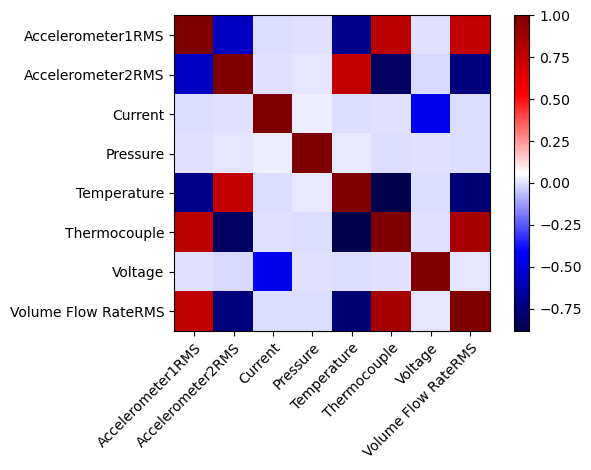

In [53]:
plt.imshow(df.corr(),cmap='seismic')
plt.colorbar()
plt.gca().set_xticks(np.arange(len(df.columns)))
plt.gca().set_yticks(np.arange(len(df.columns)))
plt.gca().set_xticklabels(labels=df.columns)
plt.gca().set_yticklabels(labels=df.columns)
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.tight_layout()
plt.show()


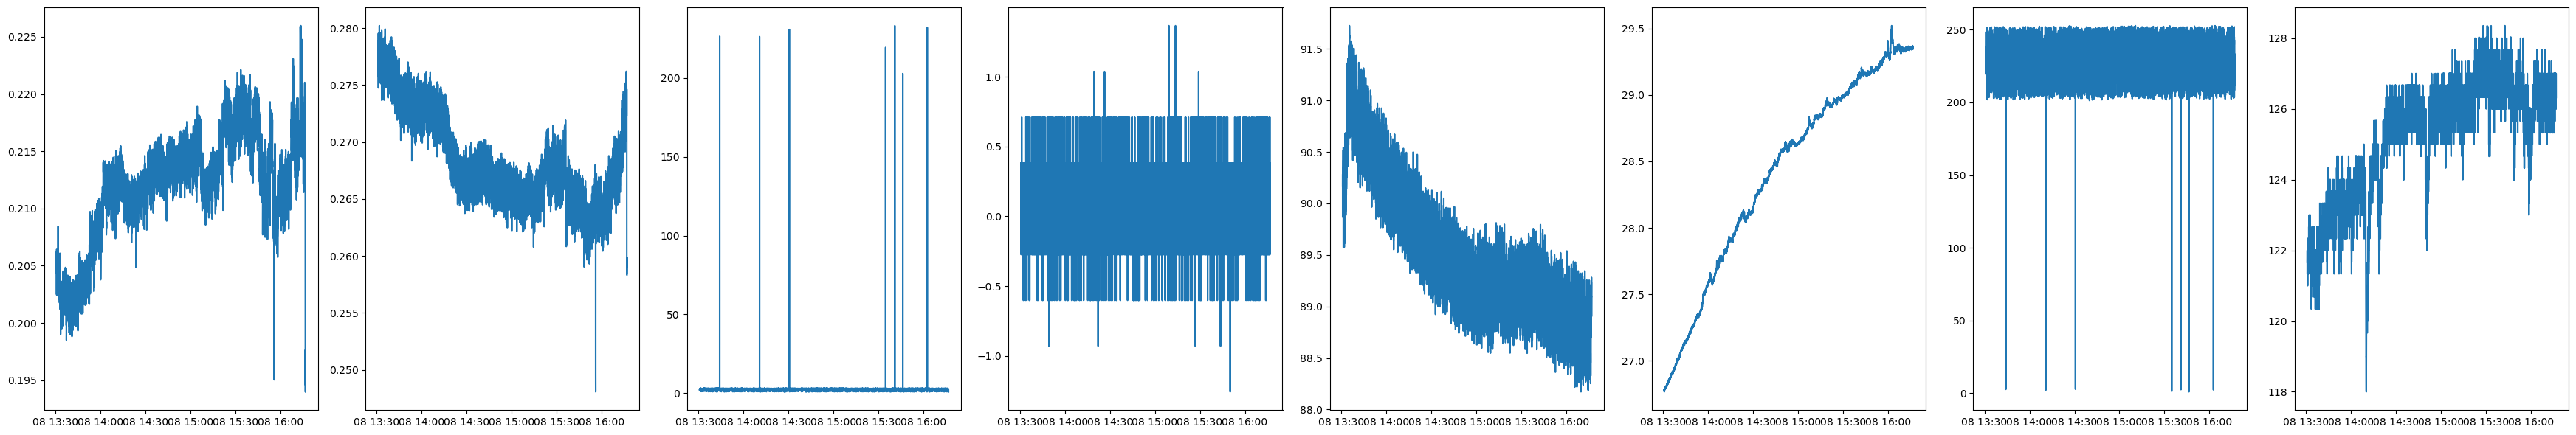

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=len(df.columns), figsize=(35, 6))

for i, col in enumerate(df):
    axs[i].plot(df[col])
plt.tight_layout()
plt.show()

### Outliers por IQR

In [7]:
def filter_outliers(column):
    column_iqr = stats.iqr(column)
    lower_bound = np.percentile(column, 25) - 1.5 * column_iqr
    upper_bound = np.percentile(column, 75) + 1.5 * column_iqr
    return column[(column >= lower_bound) & (column <= upper_bound)]

df_iqr = df.apply(filter_outliers, axis=0).dropna()

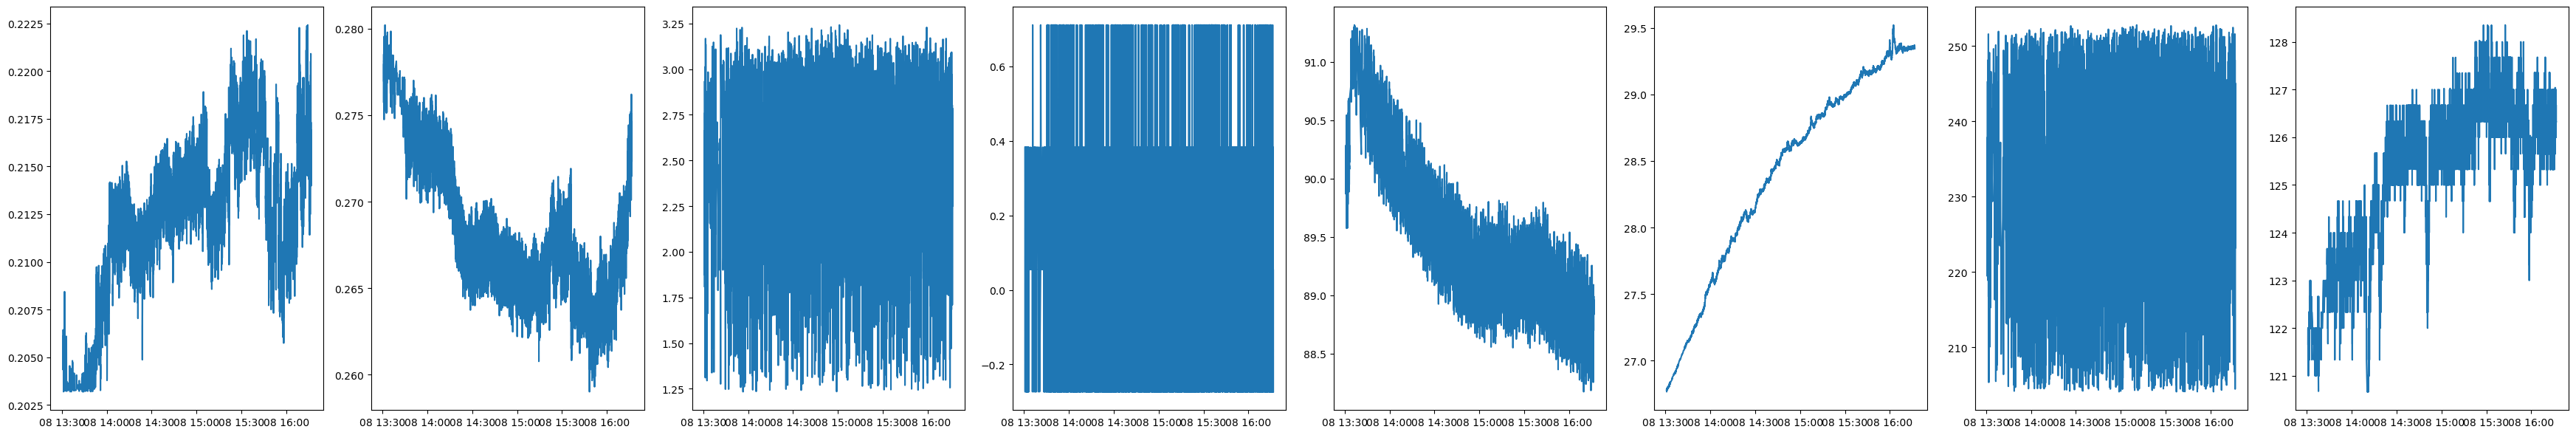

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=len(df.columns), figsize=(35, 6))
for i, col in enumerate(df_iqr):
    axs[i].plot(df_iqr[col])
plt.tight_layout()
plt.show()

### Outliers por hampel

peguei de https://github.com/dwervin/pyhampel

tem tambem o pacote hampel pra ser instalado via pip, mas precisa instalar o C++ compiler e eu não tava afim

In [9]:
def hampel_filter_df(df: pd.DataFrame, vals_col: str, time_col=None, win_size=30, num_dev=3, center_win=True) -> pd.DataFrame:
    """
    This function takes in dataframe containing time series of values, applies Hampel filter on
    these values, and returns dataframe consisting of original values columns along with
    the Hampel filtered data, outlier values and boolean flags where outliers found.

    Parameters
    ----------
    df: pd.DataFrame
        data from containing time series that needs to be Hampel filtered
    vals_col: str
        Single column name that contains values that need to be filtered.
    time_col: str
        Name of column that contains dates or timestamps
    win_size: int
        Size of sliding window for filtering.  Essentially the number of time steps to be considered when filtering.
    num_dev: int
        Number of standard deviations to consider when detecting values that would be considered outliers.
    center_win: Boolean
        Boolean value that determines whether the window is centered about the point being filtered?  Default=True.
        If False, point is at the leading edge (i.e. right side) of window  calculation.

    Returns
    -------
    Function returns a full dataframe consisting of original values columns along with
    the Hampel filtered data, outlier values and boolean flags where outliers found.
    """
    #print("IN HAMPEL_FILTER_DF")

    if (time_col != None):
        if (time_col not in list(df.columns)):
            raise Exception("Timestamp column '{}' is missing!".format(time_col))
        elif (time_col in list(df.columns)):
            if (not np.issubdtype(df[time_col].dtype, np.datetime64)):
                if (not np.issubdtype(pd.to_datetime(df[time_col]).dtype, np.datetime64)):
                    raise Exception("Timestamp column '{}' is not np.datetime64".format(time_col))
                else:
                    df[time_col] = pd.to_datetime(df[time_col])
                    drop_cols = set(df.columns) - set([time_col, vals_col])
                    # Not really filtered at this point. Just naming appropriately ahead of time.
                    orig_vals = df.sort_values(time_col, ascending=True).set_index(time_col).copy()
                    filtered = orig_vals.drop(columns=drop_cols).copy()
            else:
                df[time_col] = pd.to_datetime(df[time_col])
                drop_cols = set(df.columns) - set([time_col, vals_col])
                # Not really filtered at this point. Just naming appropriately ahead of time.
                orig_vals = df.sort_values(time_col, ascending=True).set_index(time_col).copy()
                filtered = orig_vals.drop(columns=drop_cols).copy()

    elif (time_col == None):
        if (not isinstance(df.index, pd.DatetimeIndex)):
            raise Exception("DataFrame index is not pd.DatetimeIndex")
        else:
            df.sort_index(inplace=True)
            drop_cols = set(df.columns) - set([vals_col])
            orig_vals = df.copy()
            filtered = orig_vals.drop(columns=drop_cols).copy()

    # Scale factor for estimating standard deviation based upon median value
    L = 1.4826

    # Calculate rolling median for the series
    rolling_median = filtered.rolling(window=int(win_size), center=center_win, min_periods=1).median()

    # Define a lambda function to apply to the series to calculate Median Absolute Deviation
    MAD = lambda x: np.median(np.abs(x - np.median(x)))

    # Calculate rolling MAD series
    rolling_MAD = filtered.rolling(window=(win_size), center=center_win, min_periods=1).apply(MAD)

    # Calculate threshold level for filtering based upon the number of standard deviation and
    # constant scaling factor L.
    threshold = int(num_dev) * L * rolling_MAD

    # Difference between original values and rolling median
    # Again, "filtered" not yet filtered at this point.
    difference = np.abs(filtered - rolling_median)

    '''
    # TODO: Look at logic here to possibly not mark as an outlier if threshold value
    is 0.0
    '''

    # Flag outliers
    outlier_idx = difference > threshold

    # Now it's filtered.  This should replace original values with filtered values from the rolling_median
    # dataframe where outliers were found.
    filtered[outlier_idx] = rolling_median[outlier_idx]
    filtered.rename(columns={vals_col: 'FLTRD_VAL'}, inplace=True)

    # Capture outliers column
    outliers = orig_vals[outlier_idx].rename(columns={vals_col: 'OUTLIER_VAL'}).drop(columns=drop_cols)
    # Capture outlier IS_OUTLIER column
    outlier_idx.rename(columns={vals_col: 'IS_OUTLIER'}, inplace=True)

    # The following returns a full dataframe consisting of original values columns
    # along with the Hampel filtered data, outlier values and boolean flags where outliers found.
    return outlier_idx

In [12]:
df_hampel = df.copy()
for col in df.columns:
    outliers = hampel_filter_df(df=df_hampel, vals_col=col, win_size=20, num_dev=3, center_win=True)
    try:
        df_hampel = df_hampel[~outliers.values]
    except:
        pass

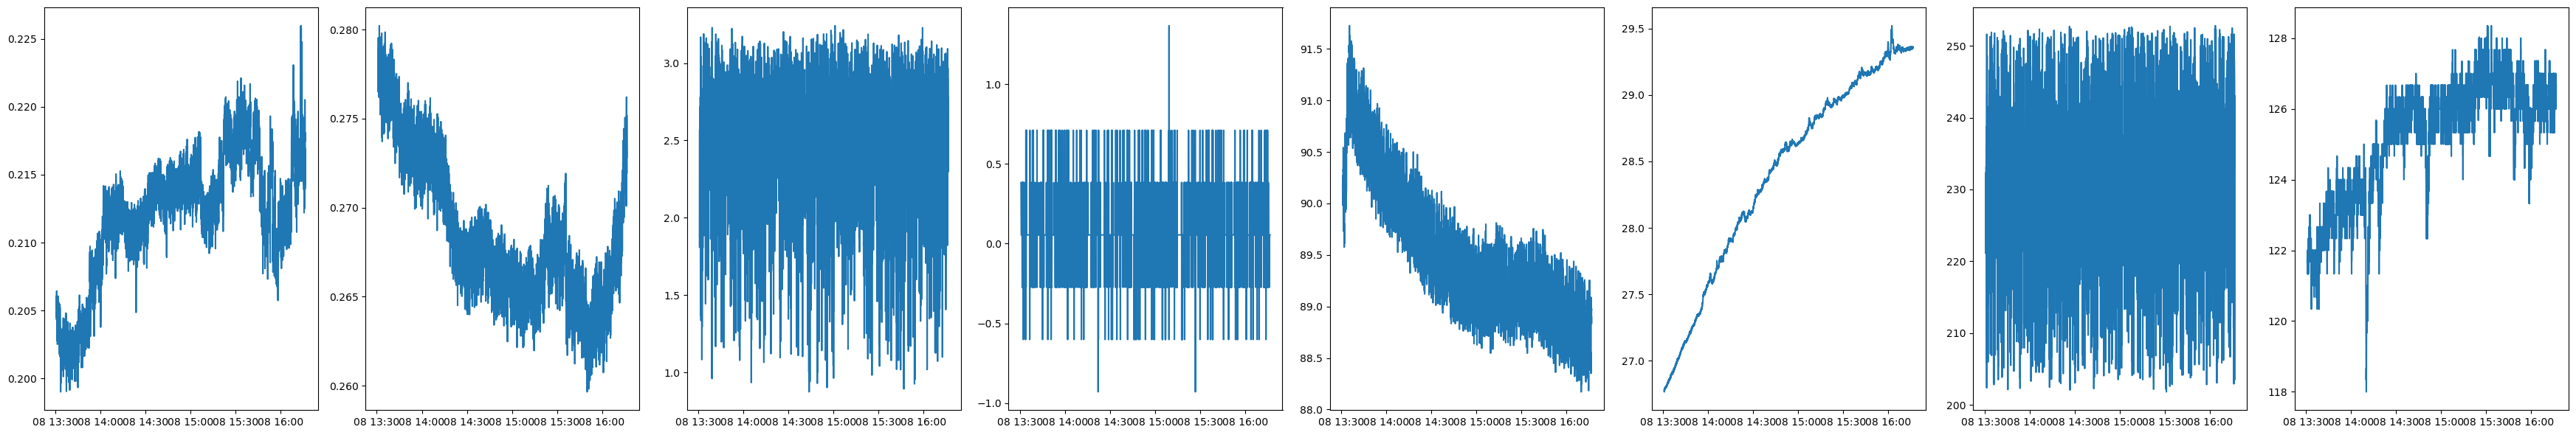

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=len(df_hampel.columns), figsize=(35, 6))
for i, col in enumerate(df_hampel):
    axs[i].plot(df_hampel[col])
plt.tight_layout()
plt.show()

### Filtro Savitzky-Golay

In [20]:
filtered_df = df_iqr.copy()
for col in df_iqr.columns:
    filtered_df[col]=signal.savgol_filter(df_iqr[col], 5, 2)

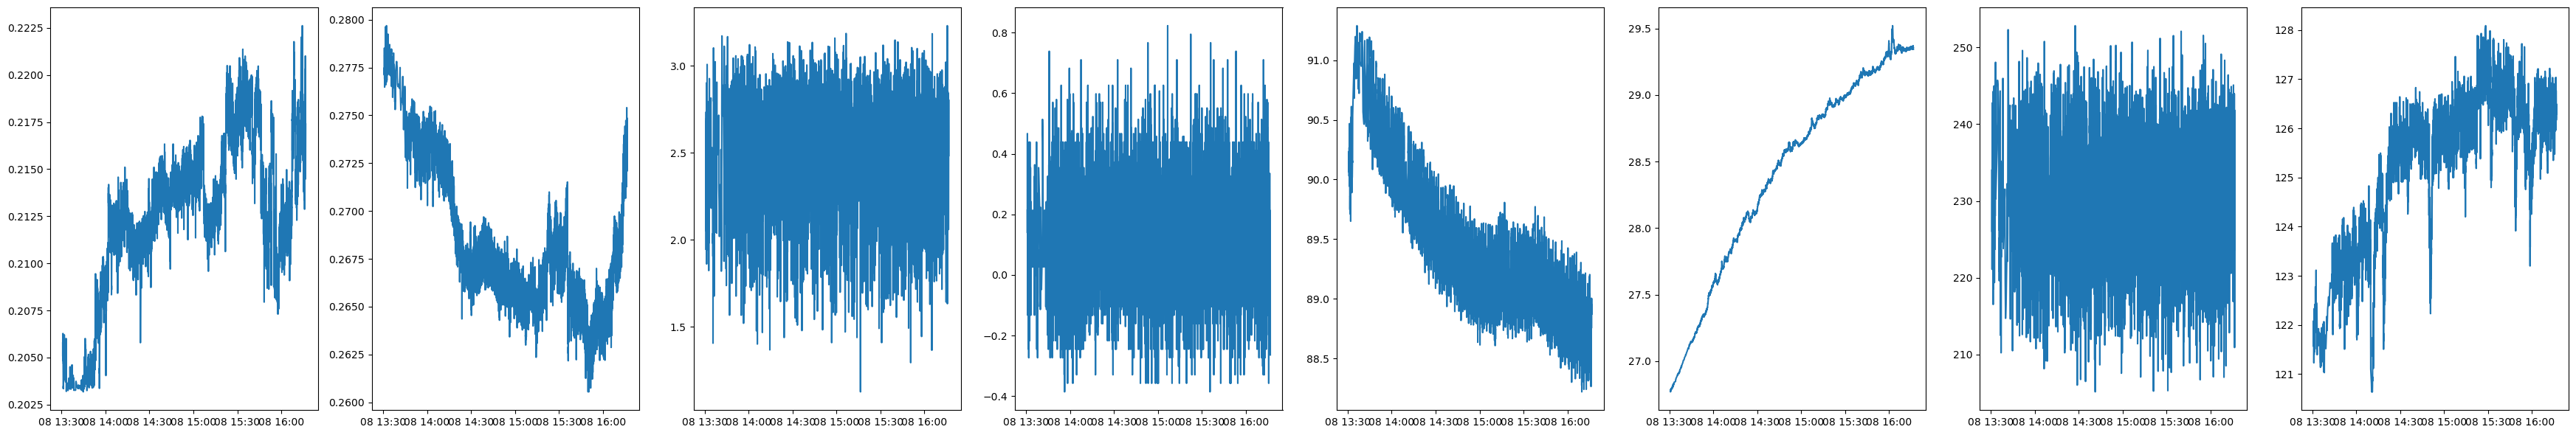

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=len(df_hampel.columns), figsize=(35, 6))
for i, col in enumerate(filtered_df):
    axs[i].plot(filtered_df[col])
plt.tight_layout()
plt.show()

### Escalonamento com MinMaxScaler

In [33]:
df_min_max = filtered_df.copy()
min_max_scaler = preprocessing.MinMaxScaler()
df_min_max[df_min_max.columns] = min_max_scaler.fit_transform(filtered_df)
df_min_max

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2020-02-08 13:30:47,0.133681,0.883809,0.389585,0.496124,0.651417,0.001796,0.438851,0.151626
2020-02-08 13:30:48,0.104956,0.865554,0.603271,0.434109,0.619366,0.002787,0.579991,0.162355
2020-02-08 13:30:49,0.096935,0.865233,0.709787,0.449612,0.606019,0.003212,0.606997,0.160008
2020-02-08 13:30:51,0.131818,0.906716,0.631595,0.705426,0.600374,0.003483,0.527430,0.124123
2020-02-08 13:30:52,0.096375,0.891909,0.660348,0.565891,0.654928,0.000974,0.334546,0.130373
...,...,...,...,...,...,...,...,...
2020-02-08 16:16:35,0.656621,0.713191,0.661045,0.232558,0.226258,0.939789,0.506330,0.744008
2020-02-08 16:16:36,0.648440,0.731914,0.677903,0.271318,0.211764,0.940571,0.512830,0.783008
2020-02-08 16:16:37,0.635655,0.645228,0.797763,0.410853,0.213813,0.940340,0.676311,0.786098


### Escalonamento com StandardScaler

In [34]:
df_standard = filtered_df.copy()
standard_scaler = preprocessing.StandardScaler()
df_standard[df_standard.columns] = standard_scaler.fit_transform(filtered_df)
df_standard

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2020-02-08 13:30:47,-1.943894,2.645964,-1.712901,0.531208,1.424079,-2.598689,-0.507487,-2.575139
2020-02-08 13:30:48,-2.093045,2.548528,-0.216998,0.093716,1.251838,-2.594643,0.433817,-2.518383
2020-02-08 13:30:49,-2.134695,2.546815,0.528664,0.203089,1.180111,-2.592908,0.613924,-2.530797
2020-02-08 13:30:51,-1.953564,2.768232,-0.018719,2.007741,1.149772,-2.591801,0.083271,-2.720621
2020-02-08 13:30:52,-2.137602,2.689200,0.182569,1.023386,1.442951,-2.602044,-1.203135,-2.687557
...,...,...,...,...,...,...,...,...
2020-02-08 16:16:35,0.771449,1.735279,0.187448,-1.328131,-0.860751,1.231227,-0.057453,0.558399
2020-02-08 16:16:36,0.728968,1.835216,0.305461,-1.054699,-0.938641,1.234421,-0.014104,0.764694
2020-02-08 16:16:37,0.662582,1.372520,1.144537,-0.070343,-0.927629,1.233476,1.076202,0.781044
